In [1]:
# !pip install imbalanced-learn --user
# !pip install delayed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading

First we load the dataset, and check for any nulls. 

In [3]:
df = pd.read_csv('data/olist_order_reviews_dataset.csv')

In [4]:
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [5]:
df.dtypes

review_id                  object
order_id                   object
review_score                int64
review_comment_title       object
review_comment_message     object
review_creation_date       object
review_answer_timestamp    object
dtype: object

In [6]:
df.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [7]:
df.isnull().count()

review_id                  100000
order_id                   100000
review_score               100000
review_comment_title       100000
review_comment_message     100000
review_creation_date       100000
review_answer_timestamp    100000
dtype: int64

In [8]:
df.nunique()

review_id                  99173
order_id                   99441
review_score                   5
review_comment_title        4600
review_comment_message     36921
review_creation_date         637
review_answer_timestamp    99010
dtype: int64

# Using Reviews to Predict Score

Problem: Given the review text, try and predict what the user rated for the product. 

We will use the text from 
1. `review_comment_title`
2. `review_comment_message`

To predict `review_score`

We will not take into account any entry that does not have at least 1 of the columns mentioned above

Methods:
- Naive Bayes
- Logistic Regression
- LSTM

In [9]:
df = df[~df['review_comment_message'].isnull() | ~df['review_comment_title'].isnull()]

In [10]:
df = df[['review_comment_title', 'review_comment_message', 'review_score']].reset_index(drop=True)

In [11]:
df = df.fillna('')
df['review'] = df['review_comment_title'] + ' ' + df['review_comment_message']
df['review'] = df['review'].str.strip()
df['length'] = df['review'].str.len()

In [12]:
df.head()

,review_comment_title,review_comment_message,review_score,review,length
0,,Recebi bem antes do prazo estipulado.,5,Recebi bem antes do prazo estipulado.,37
1,,Parabéns lojas lannister adorei comprar pela I...,5,Parabéns lojas lannister adorei comprar pela I...,100
2,recomendo,aparelho eficiente. no site a marca do aparelh...,4,recomendo aparelho eficiente. no site a marca ...,184
3,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,"Mas um pouco ,travando...pelo valor ta Boa.",43
4,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5,"Super recomendo Vendedor confiável, produto ok...",72


# Analysis

count    43482.000000
mean         3.674417
std          1.614854
min          1.000000
25%          2.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: review_score, dtype: float64


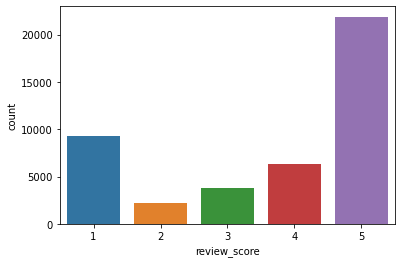

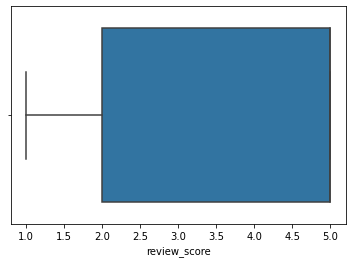

In [13]:
print(df['review_score'].describe())
sns.countplot(x="review_score", data=df)
plt.show()
sns.boxplot(x="review_score", data=df)

# Review Score
The review score ranged from 1-5, with a mean of 3.67, and most of the reviews being a 5

count    43482.000000
mean        70.435606
std         55.871351
min          0.000000
25%         28.000000
50%         55.000000
75%         98.000000
max        229.000000
Name: length, dtype: float64


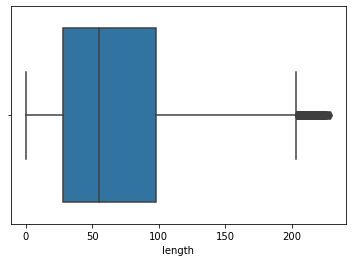

In [14]:
print(df['length'].describe())
sns.boxplot(x="length", data=df)

# Review
Each review is 0-229 characters long, with an average of roughly 70 characters. About a sentence

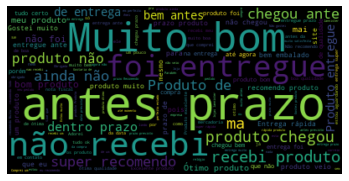

In [15]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Generate wordcloud
def generateWordCloud(text):
    wordcloud = WordCloud().generate(text)

    # Show wordcloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
generateWordCloud(" ".join(review for review in df['review']))


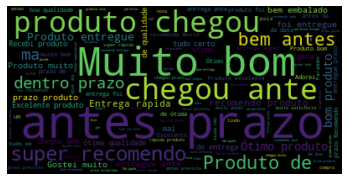

In [16]:
generateWordCloud(" ".join(review for review in df[df['review_score'] > 3]['review']))

- antes prazo: before deadline
- produto chegou: product arrived
- super recomendo: super recommended
- chegou ante: arrived before
- dentro prazo: within term
- muito bom: very good

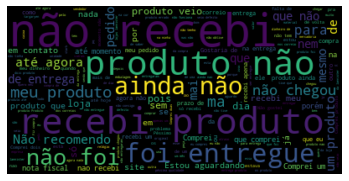

In [17]:
generateWordCloud(" ".join(review for review in df[df['review_score'] < 3]['review']))

- não recebi: not received
- produto não: no product
- não recomendo: not recommended
- ainda não: not yet
- foi entregue: was delivered
- não foi: it was not

# Pre-processing of Text

1. We combine the review title and review together
2. We remove any review less than 10 characters long. Single word reviews are not very helpful
2. We remove any punctuation, newlines, excess whitespace, stopwords, numbers
3. Stem the words

https://towardsdatascience.com/review-rating-prediction-a-combined-approach-538c617c495c

https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908

https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

https://towardsdatascience.com/a-beginners-guide-to-sentiment-analysis-in-python-95e354ea84f6

[TFIDF Information](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)

We will use TF-IDF (Term Frequency–Inverse Document Frequency) to encode the sentences
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents.

In [18]:
# Remove stopwords
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer # Portuguese stemmer

nltk.download('stopwords')
nltk.download('rslp')
portuguese_stopwords = stopwords.words('portuguese')
stemmer = nltk.stem.RSLPStemmer()

def process_text(text):
    text = ''.join([c for c in text if c not in string.punctuation]) # Remove punctuation
    text = ''.join([c for c in text if not c.isdigit()]) # Remove numbers
    text = text.lower().strip() # Lowercase and strip
    
    # remove stopwords and stem
    text = [stemmer.stem(word) for word in text.split() if word not in portuguese_stopwords] 
    return ' '.join(text)

df = df[df['length'] > 10]
df['review'] = df['review'].apply(lambda x: process_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tohho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\tohho\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


       word   freq
36   produt  21244
38   entreg  12913
3      praz   8533
9     compr   7713
0     receb   7008
23     cheg   6646
16    recom   5886
2       ant   5728
72      bom   4853
144     vei   3418
45     ótim   3337
1       bem   3126
6       loj   2950
118    qual   2867
33      sup   2591
116   rápid   2570
39     gost   2514
71     aind   2453
108     tud   2334
254     dia   2312


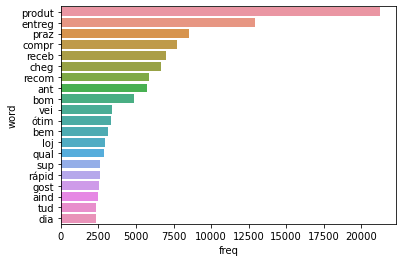

In [19]:
word_freqs = {}
for sentence in df['review']:
    for word in sentence.split():
        if word in word_freqs:
            word_freqs[word] += 1
        else:
            word_freqs[word] = 1
            
df_word_freqs = pd.DataFrame(word_freqs.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False)
print(df_word_freqs.head(20))
sns.barplot(y='word', x='freq', data=df_word_freqs.head(20))

In [20]:
X = df['review']
y = df['review_score']

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

def testClassifier(clf, X, y, X_transformer=None, y_transformer=None, plot_confusion_matrix=False, include_f1=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    if X_transformer:
        X_train = X_transformer.fit_transform(X_train)
        X_test = X_transformer.transform(X_test)
    if y_transformer:
        y_train = y_transformer.fit_transform(y_train)
        y_test = y_transformer.fit_transform(y_test)
    
    print(clf.fit(X_train, y_train))
    cross_validation_scores = cross_val_score(clf, X_test, y_test, cv=5)
    print(f"Average 5-fold cross validation score: {sum(cross_validation_scores)/len(cross_validation_scores)}")
    print(f"Score: {clf.score(X_test, y_test)}")
    
    if include_f1:
        print(f"F1: {f1_score(y_test, clf.predict(X_test), average='weighted')}")
    print("\n")
    
    if plot_confusion_matrix:
        ax = plt.axes()
        sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt="d", ax=ax)
        ax.set_title(clf.__str__())
        plt.show()

In [22]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

testClassifier(LinearRegression(), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(LogisticRegression(class_weight='balanced', max_iter=1000), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(Ridge(), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(Lasso(), X, y, TfidfVectorizer(), None, include_f1=False)

LinearRegression()
Average 5-fold cross validation score: 0.3001175166120503
Score: 0.489304642826776


LogisticRegression(class_weight='balanced', max_iter=1000)
Average 5-fold cross validation score: 0.5607852215015356
Score: 0.5764476803250931


Ridge()
Average 5-fold cross validation score: 0.6032003010572281
Score: 0.621033096800736


Lasso()
Average 5-fold cross validation score: -0.0008866783655399058
Score: -4.746947046330163e-06




MultinomialNB()
Average 5-fold cross validation score: 0.65298048556224
Score: 0.666948865560447
F1: 0.5670253824763417




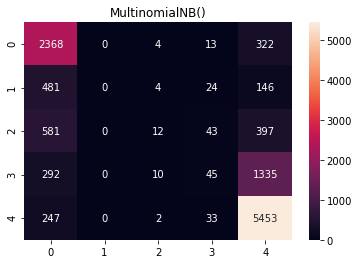

BernoulliNB()
Average 5-fold cross validation score: 0.6339315219140124
Score: 0.6497629529292245
F1: 0.5914168967773793




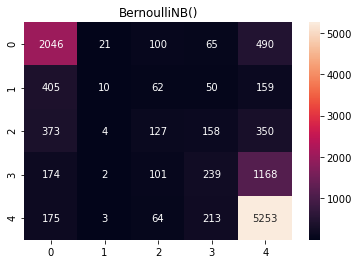

ComplementNB()
Average 5-fold cross validation score: 0.658652533071416
Score: 0.6632238401625465
F1: 0.5984947711459274




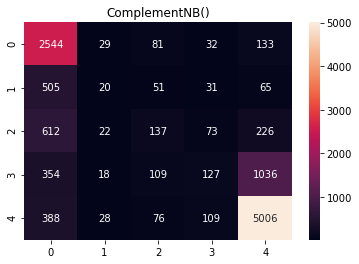

In [23]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(BernoulliNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(ComplementNB(), X, y, TfidfVectorizer(), None, True)
# testClassifier(GaussianNB(), X, y, TfidfVectorizer(), None, True)

KNeighborsRegressor()
Average 5-fold cross validation score: -0.04103228654720412
Score: 0.19490478016787227


KNeighborsClassifier()
Average 5-fold cross validation score: 0.5033008887008041
Score: 0.5390281070098205
F1: 0.4724895505054597




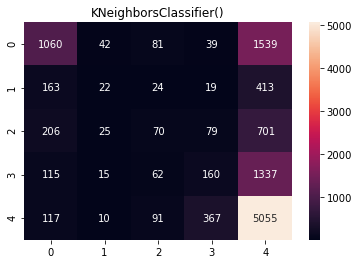

In [24]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
testClassifier(KNeighborsRegressor(), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(KNeighborsClassifier(), X, y, TfidfVectorizer(), None, True)

DecisionTreeClassifier(max_depth=10)
Average 5-fold cross validation score: 0.5613779395370987
Score: 0.5709448018963765
F1: 0.4988608681199791




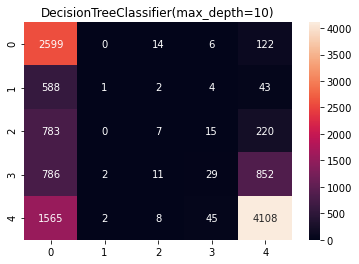

In [25]:
from sklearn.tree import DecisionTreeClassifier

testClassifier(DecisionTreeClassifier(max_depth=10), X, y, TfidfVectorizer(), None, True)

Let's also compare between 
- `TfidfVectorizer`
- `CountVectorizer`

MultinomialNB()
Average 5-fold cross validation score: 0.656281410096309
Score: 0.6689806975956655
F1: 0.5665132094528529




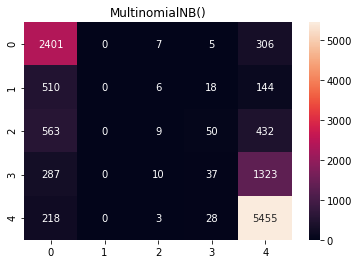

MultinomialNB()
Average 5-fold cross validation score: 0.6695739030631349
Score: 0.6722824246528953
F1: 0.6139030609644504




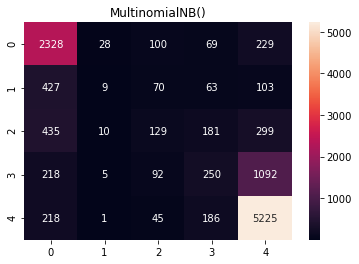

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(MultinomialNB(), X, y, CountVectorizer(), None, True)

From the results above, there is not much difference between the `TfidfVectorizer` and `CountVectorizer`

# Predicting sentiment based on review

Instead of predicting the score (1-5), lets predict whether we get a positive/negative review. We shall consider <= 3 as a negative review, and everything else as a positive review

In [27]:
df['is_positive'] = df['review_score'] > 3

In [28]:
df.head()

,review_comment_title,review_comment_message,review_score,review,length,is_positive
0,,Recebi bem antes do prazo estipulado.,5,receb bem ant praz estipul,37,True
1,,Parabéns lojas lannister adorei comprar pela I...,5,parabém loj lannist ador compr internet segur ...,100,True
2,recomendo,aparelho eficiente. no site a marca do aparelh...,4,recom aparelh efici sit marc aparelh impress d...,184,True
3,,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,pouc travandopel val ta boa,43,True
4,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",5,sup recom vend confi produt ok entreg ant praz,72,True


In [29]:
X = df['review']
y = df['is_positive']

testClassifier(LinearRegression(), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(LogisticRegression(class_weight='balanced', max_iter=1000), X, y, TfidfVectorizer(), None)
testClassifier(Ridge(), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(Lasso(), X, y, TfidfVectorizer(), None, include_f1=False)

LinearRegression()
Average 5-fold cross validation score: 0.24245190409577594
Score: 0.4190253302003829


LogisticRegression(class_weight='balanced', max_iter=1000)
Average 5-fold cross validation score: 0.875380468648939
Score: 0.8833389773112089
F1: 0.8843853554582694


Ridge()
Average 5-fold cross validation score: 0.5433610780739325
Score: 0.5647585671400233


Lasso()
Average 5-fold cross validation score: -0.0004975989195477482
Score: -0.0006949074688737955




MultinomialNB()
Average 5-fold cross validation score: 0.8725021974749732
Score: 0.8813918049441246
F1: 0.881199788783621




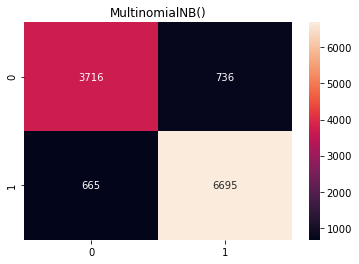

BernoulliNB()
Average 5-fold cross validation score: 0.8366058301438741
Score: 0.8479512360311547
F1: 0.8463691497428296




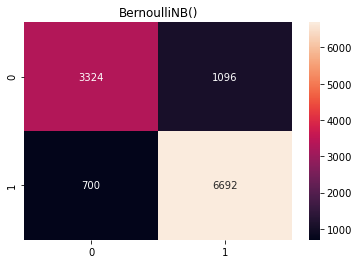

ComplementNB()
Average 5-fold cross validation score: 0.8719101244381792
Score: 0.8735184558076532
F1: 0.8744770807889392




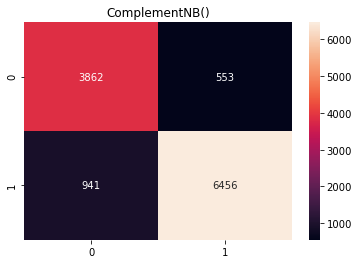

In [30]:
testClassifier(MultinomialNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(BernoulliNB(), X, y, TfidfVectorizer(), None, True)
testClassifier(ComplementNB(), X, y, TfidfVectorizer(), None, True)
# testClassifier(GaussianNB(), X, y, TfidfVectorizer(), None, True)

KNeighborsRegressor()
Average 5-fold cross validation score: 0.14333899539308845
Score: 0.21216794542021566


KNeighborsClassifier()
Average 5-fold cross validation score: 0.720960095001152
Score: 0.7307822553335591
F1: 0.6934965865594964




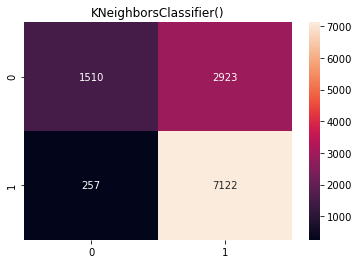

In [31]:
testClassifier(KNeighborsRegressor(), X, y, TfidfVectorizer(), None, include_f1=False)
testClassifier(KNeighborsClassifier(), X, y, TfidfVectorizer(), None, True)

We can see that, we are able to classify with ~85% accuracy, the sentiment of the review based on the text of the review

# Fine Tuning Classifier

Let's use a `ComplementNB` with a `CountVectorizer`. We will also tackle more problems

1. We will tackle the problem of class imbalance using [SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/), a way to synthetically generate minority sample
2. We will also do some hyperparameter tuning to figure out the best set of parameters for `MultinomialNB`

In [32]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import BorderlineSMOTE 

# Split to train/test sets
X = df['review']
y= df['review_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Transform with our vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# FIx class imbalance
sm = BorderlineSMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)

Best score: 0.642818635822269, Best parameters: {'alpha': 0.01, 'fit_prior': True}
Validation Score: 0.5911279617785242
f1: 0.5911279617785242


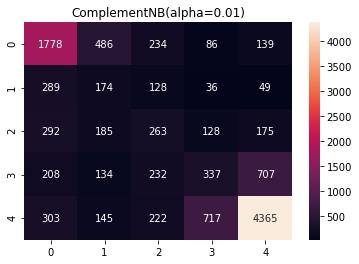

In [33]:
params = dict(
    alpha=[0.01, 0.05, 0.1, 0.5, 1.0],
    fit_prior=[True, False]
)
skf = StratifiedKFold(shuffle=True)
cnb = ComplementNB()

clf = GridSearchCV(cnb, params, cv=skf, scoring='f1_weighted')
clf.fit(X_train, y_train)
print(f"Best score: {clf.best_score_}, Best parameters: {clf.best_params_}")

clfNB = ComplementNB(**clf.best_params_)
clfNB.fit(X_train, y_train)

print(f"Validation Score: {clf.score(X_test, y_test)}")
print(f"f1: {f1_score(y_test, clf.predict(X_test), average='weighted')}")

ax = plt.axes()
sns.heatmap(confusion_matrix(y_test, clfNB.predict(X_test)), annot=True, fmt="d", ax=ax)
ax.set_title(clfNB.__str__())
plt.show()

We also have `Ridge` being the best regressor for the problem.

In [34]:
params = dict(
    alpha=[0.01, 0.05, 0.1, 0.5, 1.0],
    normalize=[True, False],
    solver=["auto", "svd", "cholesky", "lsqr"]
)

skf = StratifiedKFold(shuffle=True)
rdg = Ridge()
clf = GridSearchCV(rdg, params, cv=skf, scoring='explained_variance')
clf.fit(X_train, y_train)
print(f"Best score: {clf.best_score_}, Best parameters: {clf.best_params_}")

clfRegression = Ridge(**clf.best_params_)
clfRegression.fit(X_train, y_train)

print(f"Validation Score: {clfRegression.score(X_test, y_test)}")

# ax = plt.axes()
# sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), annot=True, fmt="d", ax=ax)
# ax.set_title(clf.__str__())
# plt.show()

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\Users\tohho\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_ridge.py", line 552, in fit
    .format(self.solver))
ValueError: solver='svd' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', or set `fit_intercept=False`

  FitFailedWarning)
C:\Users\tohho\AppData\Roaming\Pyth

Best score: 0.6614122549956043, Best parameters: {'alpha': 0.1, 'normalize': False, 'solver': 'auto'}
Validation Score: 0.5490379706705004


In [35]:
def make_predict(clf, vectorizer):
    def predict(text):
        transformed_text = process_text(text)
        transformed_text = vectorizer.transform([transformed_text])
        return clf.predict(transformed_text)[0]
    return predict

reviews = [
    'produto ruim', # bad product
    'produto excelente', # excellent product
    'este foi um ótimo produto que chegou na hora', # this was a great product that arrived on time
    'este foi um ótimo produto, mas chegou tarde', # this was a great product, but it came late
]
    
predictDiscrete = make_predict(clfNB, vectorizer)
predictContinuous = make_predict(clfRegression, vectorizer)

for review in reviews:
    print(f"Discrete prediction: {predictDiscrete(review)}, Continuous prediction: {predictContinuous(review)}")

Discrete prediction: 2, Continuous prediction: 1.9133624322075347
Discrete prediction: 5, Continuous prediction: 4.612956510116991
Discrete prediction: 5, Continuous prediction: 3.7387435773508866
Discrete prediction: 2, Continuous prediction: 2.2758799251686153


In [36]:
review_from_df = df[df['review_score'] == 2].iloc[4]['review_comment_message']
print(predictDiscrete(review_from_df))
print(predictContinuous(review_from_df))

3
2.931901410032171


# Saving and Loading Models

To save and load models, use `pickle`

In [37]:
import pickle

vectorizer_filename = 'vectorizer.sav'

pickle.dump(clfNB, open('NBClassifier.sav', 'wb'))
pickle.dump(clfRegression, open('RidgeClassifier.sav', 'wb'))
pickle.dump(vectorizer, open(vectorizer_filename, 'wb'))

In [38]:
with open('NBClassifier.sav', 'rb') as f:
    model = pickle.load(f)
with open(vectorizer_filename, 'rb') as f:
    vectorizer = pickle.load(f)

predict = make_predict(model, vectorizer)

print(predict("nunca chegou")) # never arrived
print(predict("belo embrulho")) # beautiful package
print(predict("qualidade ruim")) # bad quality

1
5
2
